In [2]:
# Before anything, import relevant modules
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data exploration

In [3]:
# First step: read data from data subdirectory
# keep only columns with time stamps and errors
df = pd.read_csv('data/HD189733_SOPHIE_listing.txt', sep='\s+', header=0, skiprows=[1,])

The SOPHIE listings contain a lot of informataion on the observations of a given target. Let's take a look at the available columns.

In [4]:
print(df.columns)
print('Number of observations', len(df))

Index(['file', 'target', 'alpha', 'delta', 'mv', 'bv', 'dpr_type', 'Texp',
       'sn6', 'sn26', 'sn35', 'mask', 'bjd', 'vrad0', 'rv_drift', 'th_flux',
       'cal_err', 'vrad', 'dvrmss', 'ccfnoise', 'svrad', 'fwhm', 'contrast',
       'biss', 'berv', 'vsini', 'feh', 'rhk', 'fibB_sn', 'fibB_cont',
       'catalog', 'back_corr', 'cti_corr', 'flux_corr', 'rv_0_35', 'rv_8_39',
       'rv_blue', 'rv_red', 'rv_high', 'rv_low', 'rv_left', 'rv_right',
       'airmass_s', 'airmass_e', 'adc_num', 'adc_angl', 'time_calib',
       'drift_interpol', 'ref_line1', 'ref_line2'],
      dtype='object')
Number of observations 63


The more relevant columns are `bjd`, which give the time of observation in Barycentric Julian Date (minus 2,400,000), `vrad`, which give the radial velocities in km/s, and `svrad` which is the associated error (containing only photon noise and calibration error).

Now, let's take a look at the RVs.

<ErrorbarContainer object of 3 artists>

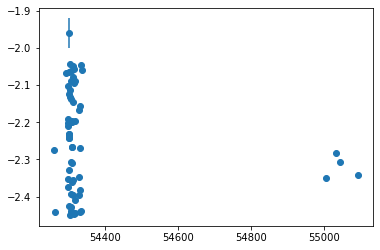

In [5]:
plt.errorbar(df.bjd, df.vrad, df.svrad, fmt='o')

We see there is a bunch of points at `bjd < 54400` and small group later on, well separated. Let's zoom on the big group.

(54250, 54350)

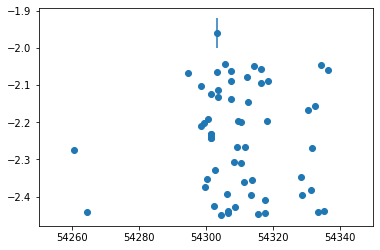

In [5]:
plt.errorbar(df.bjd, df.vrad, df.svrad, fmt='o')
plt.xlim(54250, 54350)

> **Important**. There is something here. The majority of data span only 40 days. This may be a problem to correctly sample the activity signal. These data set may not be the best to perform ICA.

For now, let's keep only those ~40 days of data.

In [6]:
# Select times in the big set
t = df.bjd
ind = (t > 54280) & (t < 54350)
t = t[ind]

print('There are {} points in the big set.'.format(sum(ind)))

There are 57 points in the big set.


## Data simulation

Now, let's use the calendar of the HD189733 data and their associated errors to build random synthetic data sets.

These data sets will contain two elements:

* A planetary (sinusoid) signal with a given period.

* A pseudo-periodic signal simulating the rotational modulation produced by star spots.

### Planetary signal

The first part is fairly simply to simulate. We just need to define an amplitude and a period (and randomly draw the phase).

Planetary parameters
Amplitude 1.0
Period 10.250449763542893
Phase 4.03617325307933


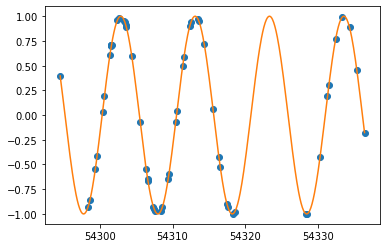

In [7]:
import numpy.random as rr

# Set seed for reproducible results
rr.seed(20200429)

# Fix amplitude to be 1.0 (arbitrary units?)
a_planet = 1.0

# Fix period by hand (maybe change in the future?)
p_planet = 10 + rr.rand()

# randomly draw phase (between 0 and 2pi)
phi_planet = rr.rand() * 2*np.pi

print('Planetary parameters')
print('Amplitude', a_planet)
print('Period', p_planet)
print('Phase', phi_planet)

# Build model 
y = a_planet * np.sin(2*np.pi/p_planet * t + phi_planet)
    
# Also produce oversampled version for plots
t_ = np.linspace(t.min(), t.max(), 500)
y_ = a_planet * np.sin(2*np.pi/p_planet * t_ + phi_planet)

# Let's take a look
plt.plot(t, y, 'o')
plt.plot(t_, y_, '-')

> **NOTE**. Check out the aliasing produced by the sampling. Let's talk about this in person. Pablo, you can also read [this article](https://drive.google.com/file/d/1G-86VtaXV7g1askBICp_oT_8qCNyv58C/view?usp=sharing) (first sections only).

(54300.0, 54320.0)

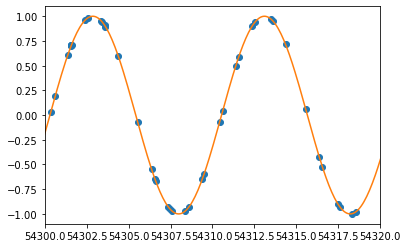

In [24]:
# Let's take a (zoomed) look
plt.plot(t, y, 'o')
plt.plot(t_, y_, '-')

plt.xlim(54300, 54320)

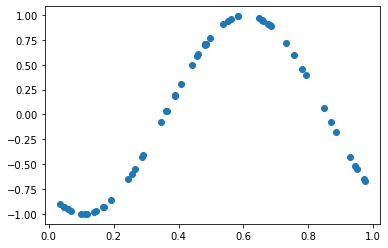

In [28]:
# And of course, if we phase-fold to the correct period...
ph = (t / p_planet) % 1
plt.plot(ph, y, 'o')

### Activity signal

The activity signal is modelled using a Gaussian process with a pseudo-periodic kernel function to describe the covarinace. This means that the points in the time series are assumed to come from a multinormal distribution, with a covariance matrix whose element $ij$ is written as:

$$
C_{ij} = \delta_{ij} \sigma_i^2 + A^2 \exp\left[-\frac{(t_i - t_j)^2}{2\tau^2} - \frac{2}{\epsilon}\sin^2{\left(\frac{\pi (t_i-t_j}{\mathcal{P}}\right)}\right]\;\;,
$$
where $\delta_{ij}$ is the Kronecker delta, which equals 1 if $i=j$ and 0 otherwise. The first term corresponds, then, to the variance of individual points due to, for example, photon noise error. The second term in the covariance matrix possesses non-diagonal elements, and represents the radial velocity effect related to the stellar rotational modulation. The parameters $\{A, \tau, \mathcal{P}, \epsilon\}$ are associated with the covariance amplitude, the evolution timescale, the recurrence timescale (the rotational period of the star), and the smoothing parameter, respectively.

To compute this, we use the (very simple) implementation in the `pygpr` package. (Pablo: you're invited to take a look at that [repository](https://github.com/exord/pygpr) too. The relevant lines in the code are:

```python
return alpha[0] ** 2 * np.exp(-0.5 * dx ** 2 / alpha[1] ** 2 - 2.0 *
                                      np.sin((np.pi * dx / alpha[2])) ** 2 /
                                      alpha[3] ** 2)

```
where `alpha` is a list with the parameters $\{A, \tau, \mathcal{P}, \sqrt{\epsilon\}}$.

We will have to adjust the parameters for this experimet, but we can try these very simple ones to star:

$A=0.5$, 1/2 the sinusoidal variation.

$\mathcal{P} \sim N(24 \text{d}, 2 \text{d})$: i.e. a normal variable distributed around some random (but raisonable) value (24 days) with some variation (2 days).

$\tau= N(2 * \mathcal{P}, 0.1 * \mathcal{P})$, about twice the rotationl period of the star (typical).

$\epsilon \sim U(0, 1)$: a uniformly distributed varible between 0 and 1.

I would love to do a [graphical representation of the model](https://en.wikipedia.org/wiki/Graphical_model), but it is not easy here. Maybe for your report?)

In [24]:
# Fix seed again
rr.seed(20200509)

# Create parameters
amp = 0.5
per = rr.randn() * 2.0 + 24.0
tau = 2 * per + rr.randn() * 0.1 * per 
epsilon = rr.rand()

# Create parameter list
theta = [amp, tau, per, np.sqrt(epsilon)]
labels = ['A', '$\\tau$', 'P', '$\\epsilon$']

from IPython.display import Markdown
for par, l in zip(theta, labels):
    display(Markdown('Parameter {} = {}'.format(l, par)))

Parameter A = 0.5

Parameter $\tau$ = 52.596220620964274

Parameter P = 24.743841011564534

Parameter $\epsilon$ = 0.8582396349485545

In [25]:
import pygpr as pygpr
from pygpr import kernels, GaussianProcess

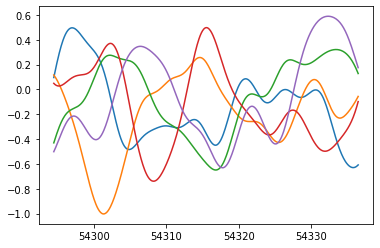

In [26]:


# Create an instance of a quasi-periodic kernel.
# Hyper parameters are: 1.0 for the amplitude and 0.1 for the length scale.
qpk = pygpr.kernels.QuasiPeriodicKernel(theta)

# Build a GP instance passing the Kernel instance and the input array 
# (timestamps in the time series and oversampled times).
mygp = pygpr.GaussianProcess.GaussianProcess(qpk, t)
mygp_ = pygpr.GaussianProcess.GaussianProcess(qpk, t_)

# Sample the GP function values (in this case, produce five random samples)
f_ = mygp_.sample(size=5)

# We can now plot the five samples.
ll = plt.plot(t_, f_.T)

This shows five typical variations that one can expect from a covariance with those parameters. 

Now let's produce an actual dataset.

Text(0, 0.5, 'RV')

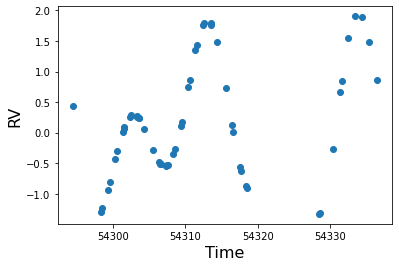

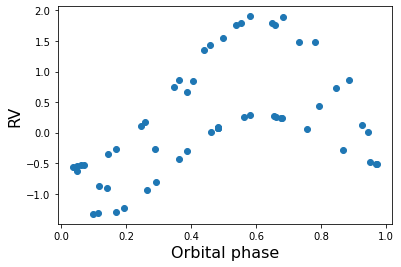

In [29]:
# Uncomment to give reproducible results
# rr.seed(20200209)

# Produce a single sample from the "activity" model.
yactivity = mygp.sample(size=1)[0]

# Combine that with the planetary signal
rv = y + yactivity

# And see what we made
plt.figure()
l0 = plt.plot(t, rv, 'o')
plt.xlabel('Time', fontsize=16)
plt.ylabel('RV', fontsize=16)

# Phase folded
plt.figure()
l1 = plt.plot(ph, rv, 'o')
plt.xlabel('Orbital phase', fontsize=16)
plt.ylabel('RV', fontsize=16)


We see the distortion produced by the second signal (no noise random noise added yet). Note that if you run the above cell again, the signal changes because of the random draw from the GP. If you want to keep the same result, uncomment the line fixing the seed.

### Combination into two channels plus noise

Now we have two noiseless signals, y (the planetary signal) and yactivity (the signal of activity). We will combine them linearly, with different weights.

Two comply with the hypothesis of ICA, we need to build an invertible, square matrix to mix the sources signals and produce the recorded ones. In the notation of the article by Shlens:

$$
\mathbf{x} = \mathcal{A}\mathbf{s}
$$

Furthermore, in our example, the planetary signal is expected to be recorded with the same amplitude on both channels. Therefore, assuming the planetary signal is the first element of the signal vector $\mathbf{s}$, the mixing matrix will have the form:

$$
\mathcal{A} =
\begin{pmatrix}
a & b\\
a & c\\
\end{pmatrix}
$$

**N.B.**: I wonder how things change in terms of solving the problem when assuming a matrix of this form instead of a general one. This may be something interesting to explore during the *stage*.

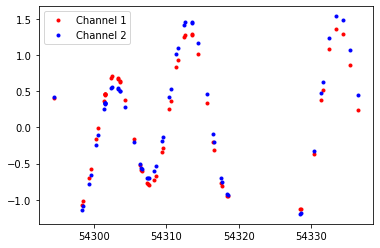

In [32]:
# Let's build the matrix (mixing matrix)
a = 1.0
b = 0.4
c = 0.6

mm = np.array([[a, b],[a, c]])

# Let's build the signal vector
s = np.array([y, yactivity])

# And produced the observed data x
x = np.dot(mm, s)

# plot
ll = plt.plot(t, x[0], '.r', label='Channel 1')
ll = plt.plot(t, x[1], '.b', label='Channel 2')
ll = plt.legend(loc=0)

To this, we must still add the diagonal noise term, which simply consists in an additional normal error on each observation.

We make two assumptions, that should be revised at some point:

* Both channels have the same noise.
* The amplitude of the noise is equal to 1/10th of the planetary signal.

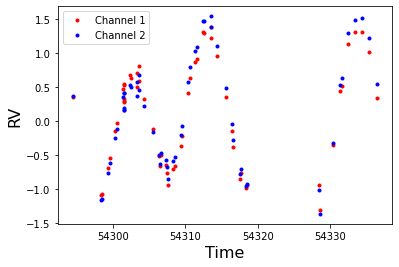

In [33]:
# To this, we must still add the diagonal noise term, which simply consists in an additional 
# normal error on each observation.
# The amplitud $\sigma_i^2$ is arbitrarily fixed to 1/10th of the variation.
# This could be revised too.

sigma_noise = 0.1
noise = rr.randn(len(y)) * sigma_noise

# Add noise
x += noise

# plot
plt.figure()
ll = plt.plot(t, x[0], '.r', label='Channel 1')
ll = plt.plot(t, x[1], '.b', label='Channel 2')
plt.xlabel('Time', fontsize=16)
plt.ylabel('RV', fontsize=16)
ll = plt.legend(loc=0)

### Save and finish

Finally, let's record the obtained signal vectors and data vectors in a file, containing the parameters used to produce the data.

In [34]:
import datetime
isodate = datetime.datetime.today().isoformat()

f = open('data/simul_{}.dat'.format(isodate), 'w')

# Write header
f.write('# Simulation for ICA\n')
f.write('# Parameters\n')
f.write('# Planet orbital period: {}\n'.format(p_planet))
f.write('# Planet velocity amplitude: {}\n'.format(a_planet))
f.write('# Planet phase: {}\n'.format(phi_planet))
f.write('# Activity covariance amplitude: {}\n'.format(amp))
f.write('# Activity covariance period: {}\n'.format(per))
f.write('# Activity coherence time: {}\n'.format(tau))
f.write('# Activity smoothing parameter: {}\n'.format(epsilon))
f.write('# Record noise: {}\n'.format(sigma_noise))

# Write data
f.write('# Columns: [time, signal in channel 1, signal in channel 2, real signal 1, real signal 2]\n')
f.write('time\tx1\tx2\ts1\ts2\n')
for i in range(len(x[0])):
    f.write('{:6f}\t{:6f}\t{:6f}\t{:6f}\t{:6f}\n'.format(t.iloc[i], x[0][i], x[1][i], s[0][i], s[1][i]))

f.close()

In [35]:
from ICA import plot_2D_distrib, ICA

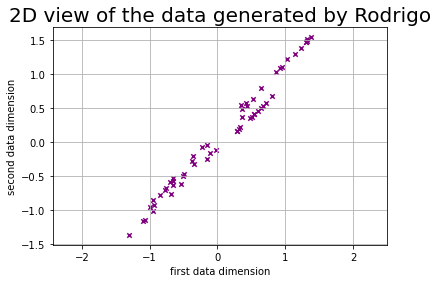

In [36]:
ax = plot_2D_distrib(x, title='generated by Rodrigo')

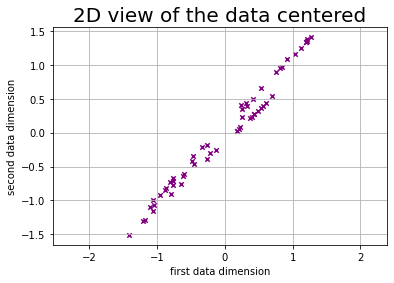

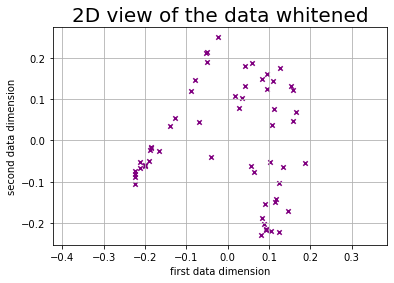

Eigenvalues in FOBI: [0.00072247 0.00077393]


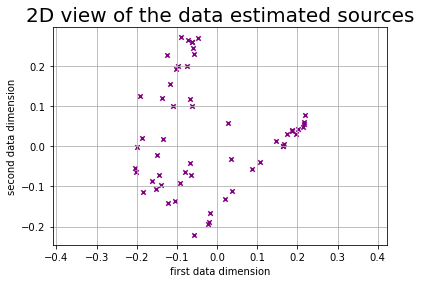

FOBI A_hat 
 [[1.         3.09238324]
 [0.56502933 3.36345594]]
re-organized FOBI A_hat 
 [[1.         0.32337518]
 [1.08765818 0.18271646]]
A_hat const-column average:  5.697821683032415
c = 5.566207945764636
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 200
            Function evaluations: 1753
            Gradient evaluations: 200
closest const-col A_hat found:
 [[nan nan]
 [nan nan]]


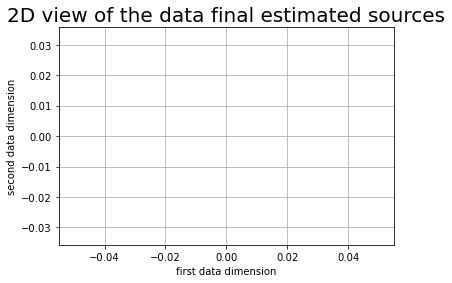

In [37]:
W, A_hat, S_hat = ICA(x, verbose=True, constraint='const-column')

In [19]:
print('A_hat = \n',A_hat,'\n\nA = \n',mm)

A_hat = 
 [[-5.31768969  2.17551723]
 [-5.31768969  2.83113721]] 

A = 
 [[1.  0.4]
 [1.  0.6]]


In [20]:
print('A_hat/A_hat[0,0] = \n',A_hat/A_hat[0,0],'\n\nA/A[0,0] = \n',mm/mm[0,0])

A_hat/A_hat[0,0] = 
 [[ 1.         -0.40910947]
 [ 1.         -0.53239985]] 

A/A[0,0] = 
 [[1.  0.4]
 [1.  0.6]]


As we can see source 2 seems to be identified up to a -1 factor.

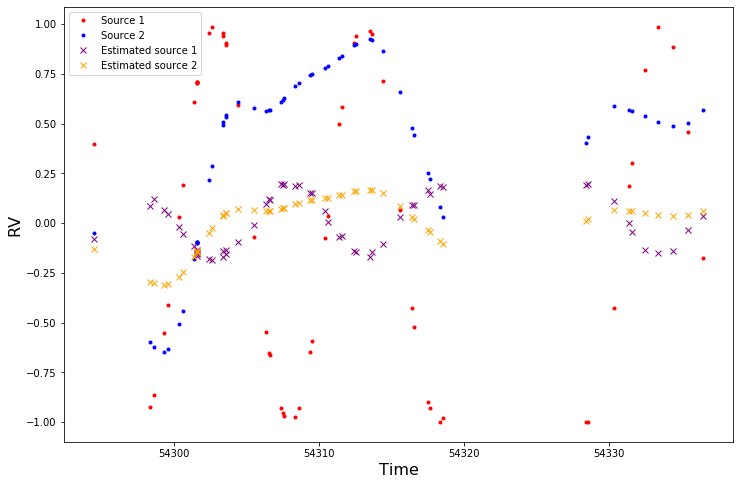

In [21]:
# plot
plt.figure(figsize=(12,8))
#plt.plot(t, x[0], '.r', label='Channel 1')
#plt.plot(t, x[1], '.b', label='Channel 2')
plt.plot(t, s[0], '.r', label='Source 1')
plt.plot(t, s[1], '.b', label='Source 2')
plt.plot(t, S_hat[0], marker='x', color='purple', label='Estimated source 1', linewidth=0)
plt.plot(t, S_hat[1], marker='x', color='orange', label='Estimated source 2', linewidth=0)
plt.xlabel('Time', fontsize=16)
plt.ylabel('RV', fontsize=16)
plt.legend(loc=0)
plt.show()
plt.close()

Also, as highlighted above, the two sources need to be scaled up by a constant factor to make a suitable graphical comparison.

In [62]:
def match_sources(s, s_hat):
    d, n = np.shape(s)
    
    # substract off the mean for each dimension
    s_av = np.reshape(np.average(s, axis=1), (d,1))
    s -= s_av  
    s_hat_av = np.reshape(np.average(s_hat, axis=1), (d,1))
    s_hat -= s_hat_av 
    s_hat *= 1/np.stack(n*(np.average(s_hat**2, axis=1)**0.5,), axis=-1)

    
    s_power = np.average(s**2, axis=1)
    s *= 1/np.stack(n*(s_power**0.5,), axis=-1)
    
    covs = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            covs[i,j] = np.average(s[i,:]*s_hat[j,:])
    
    print('Covariance matrix between real sources and estimated sources\n',covs)
    
    s_hat_ordered = np.zeros((d,n))
    
    for i in range(d):
        ind = np.argmax(abs(covs[i,:]))
        print("Source ",i," labelled as ", ind, " cov:",covs[i,ind])
        s_hat_ordered[i,:] = s_hat[ind,:]*np.sign(covs[i,ind])
        if np.argmax(abs(covs[:,ind]))!=i:
            print("But estimated source ", ind, " is closer to source ", np.argmax(abs(covs[:,ind])))
    
    return s_hat_ordered*np.stack(n*(s_power**0.5,), axis=-1) + s_av

Covariance matrix between real sources and estimated sources
 [[-9.64223134e-01  1.45486402e-01]
 [-8.11507124e-11  1.00000000e+00]]
Source  0  labelled as  0  cov: -0.964223133640148
Source  1  labelled as  1  cov: 1.0000000000000002


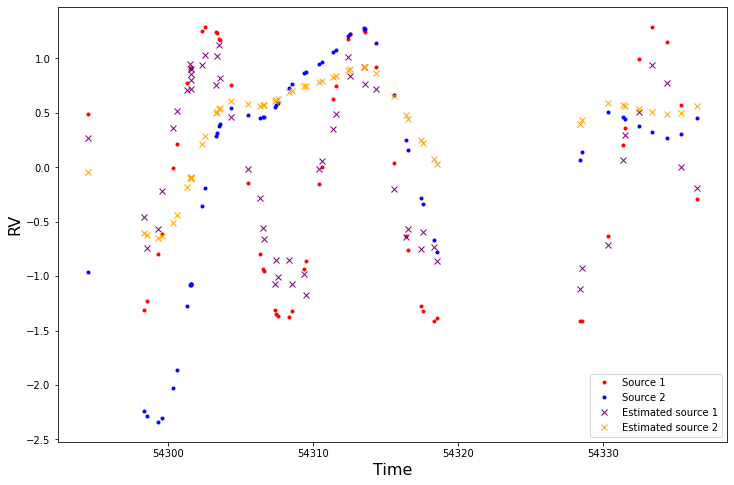

In [63]:
# plot
plt.figure(figsize=(12,8))

S_hat_matched = match_sources(s, S_hat)

plt.plot(t, s[0], '.r', label='Source 1')
plt.plot(t, s[1], '.b', label='Source 2')
plt.plot(t, S_hat_matched[0], marker='x', color='purple', label='Estimated source 1', linewidth=0)
plt.plot(t, S_hat_matched[1], marker='x', color='orange', label='Estimated source 2', linewidth=0)
plt.xlabel('Time', fontsize=16)
plt.ylabel('RV', fontsize=16)
plt.legend(loc=0)
plt.show()
plt.close()

# <center>Now the match is pretty good!</center>